<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC 
## Search and access with ACTRIS Data Portal and json

In [6]:
# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

# Libraries for working with json files
import json
import requests
import os

## Access data from example on Search with ACTRIS Data Portal

The previous example includes two methods of accessing the data: 
- THREDDS Data Catalog - Opendap protocol (Streaming of data)
- THREDDS Data Catalog - HTTPS protocol (Download of data)

You only need to run one of the protocols to get the dataset in question for the analysis. 

In [15]:
protocol = 'opendap' # choose 'http' or 'opendap'

In [ ]:
# Check filepath 
folder = os.getcwd().replace("  Analyse ACTRIS data", "   Search and access") ## Change the folder name to the folder where the data is stored
print(folder)

/home/lemu/repos/actris-jupyter-hub/   Search and access


In [14]:
os.chdir(folder)

f = open('static/basket.json') # open the file "basket.json"
md = json.load(f) # load the json file

if protocol == 'http': 
    if os.path.exists("static/data_oc_ec"): 
        print("The data folder exists")
    else:
        print("The data folder does not exist, here is the short version. To get more information about this protocol see the first example.")
        
        f = open('static/basket.json') # open the file "basket.json"
        md = json.load(f) # load the json file
        os.makedirs("static/data_oc_ec")
        for i in md: 
            r = requests.get(md[i]['downloadUrl'])
            filename = r.url[-12:]
            filepath = os.path.join("static/data_oc_ec", filename)  # Specify the folder path
            with open(filepath, mode="wb") as file:
                file.write(r.content)

## Data processing

Depending on the type of data, the documentation for each file can be found here: https://data.actris.eu/docs 

Since this is an In-Situ dataset the documentation is found here: https://ebas.pages.nilu.no/ebas-io/fileformat_netcdf/index.html 

In [9]:
ds_elemental_carbon = []  # Create an empty list to store elemental carbon data
ds_organic_carbon = []  # Create an empty list to store organic carbon data
ds_total_carbon = []  # Create an empty list to store total carbon data

for i in md:  # Iterate over the keys in the 'md' dictionary

    if protocol == 'opendap':
        ds = xr.open_dataset(md[i]['opendapUrl'])
    elif protocol == 'http':
        filename = md[i]['downloadUrl'][-12:]
        ds = xr.open_dataset('data_oc_ec/{}'.format(filename))  
    
    for j in list(ds.data_vars.keys()):  # Iterate over the variables in the dataset
        attrs = ds[j].attrs  # Get the attributes of the variable
        
        # Check if the variable is elemental carbon with specific attributes
        if attrs.get('standard_name') == 'mass_concentration_of_elemental_carbon_in_pm10_in_air' and \
           attrs.get('ebas_statistics') == 'arithmetic mean' and \
           attrs.get('units') == 'ug C/m3':
            ds_elemental_carbon.append(ds[j])  # Add the variable to the elemental carbon list
        
        # Check if the variable is organic carbon with specific attributes
        elif attrs.get('standard_name') == 'mass_concentration_of_organic_carbon_in_pm10_in_air' and \
             attrs.get('ebas_statistics') == 'arithmetic mean' and \
             attrs.get('units') == 'ug C/m3':
            if 'Fraction' not in ds[j].dims and 'Fractionx' not in ds[j].dims and 'Fractionxx' not in ds[j].dims:
                ds_organic_carbon.append(ds[j])  # Add the variable to the organic carbon list
        
        # Check if the variable is total carbon with specific attributes
        elif attrs.get('standard_name') == 'mass_concentration_of_total_carbon_in_pm10_in_air' and \
             attrs.get('ebas_statistics') == 'arithmetic mean' and \
             attrs.get('units') == 'ug C/m3':
            ds_total_carbon.append(ds[j])  # Add the variable to the total carbon list

In [10]:
# Sort the ds_elemental_carbon list based on the first time value in each DataArray
ds_elemental_carbon.sort(key=lambda x: x.time.values[0] if len(x.time) > 0 else np.datetime64('NaT'))

# Sort the ds_organic_carbon list based on the first time value in each DataArray
ds_organic_carbon.sort(key=lambda x: x.time.values[0] if len(x.time) > 0 else np.datetime64('NaT'))

# Sort the ds_total_carbon list based on the first time value in each DataArray
ds_total_carbon.sort(key=lambda x: x.time.values[0] if len(x.time) > 0 else np.datetime64('NaT'))

In [11]:
# Concatenate the list of DataArrays in ds_elemental_carbon along the 'time' dimension
ec_ds = xr.concat([ds for ds in ds_elemental_carbon], dim='time')

# Concatenate the list of DataArrays in ds_organic_carbon along the 'time' dimension
oc_ds = xr.concat([ds for ds in ds_organic_carbon], dim='time')

# Concatenate the list of DataArrays in ds_total_carbon along the 'time' dimension
tc_ds = xr.concat([ds for ds in ds_total_carbon], dim='time')

## Data visualisation

Using matplotlib to create a timeseries plot of elemental carbon and organic carbon at Birkenes 

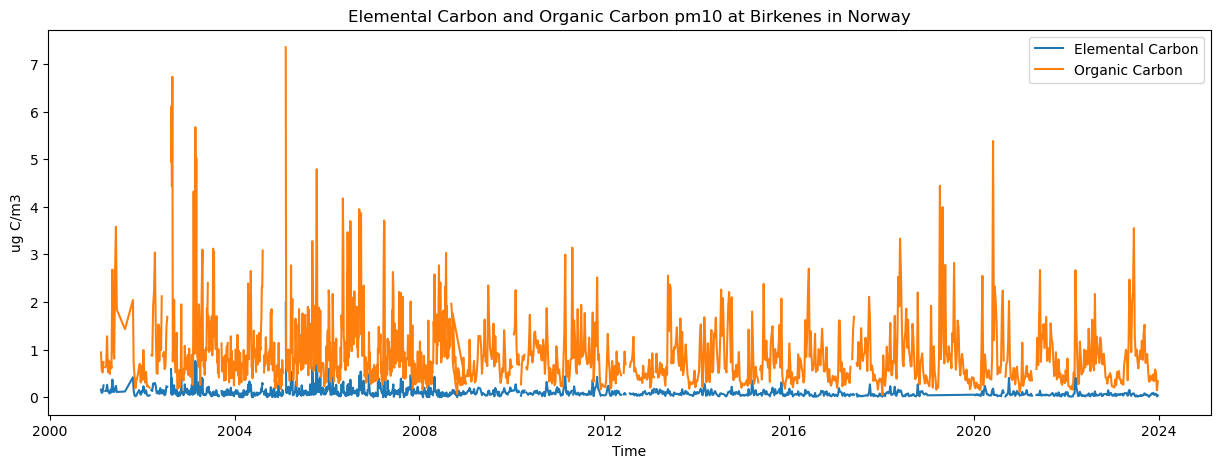

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(ec_ds.time, ec_ds, label='Elemental Carbon')
plt.plot(oc_ds.time, oc_ds, label='Organic Carbon')
#plt.plot(tc_ds.time, tc_ds, label='Total Carbon')
plt.legend()
plt.ylabel('ug C/m3')
plt.xlabel('Time')
plt.title('Elemental Carbon and Organic Carbon pm10 at Birkenes in Norway')
plt.show()